In [1]:
import statsmodels.api as sm

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc

from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from itertools import product

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['lines.linewidth'] = 1
plt.style.use('fivethirtyeight')

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("dataset/rolling_mean_imputation.csv")

In [3]:
train_df = train_df.drop(['Unnamed: 0'], axis=1)
train_df.rename(columns={'All_date':'Date'}, inplace=True)

In [4]:
train_df.tail()

,Date,Close
7424,2020-12-27,2.580148
7425,2020-12-28,2.305000
7426,2020-12-29,2.467000
7427,2020-12-30,2.422000
7428,2020-12-31,2.539000


In [5]:
train_df.Date = pd.to_datetime(train_df.Date, infer_datetime_format=True)

In [6]:
train_df=train_df.set_index('Date')

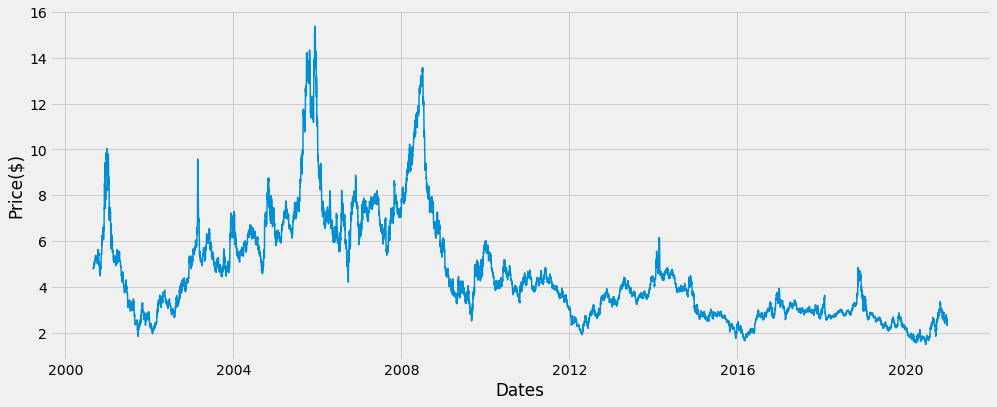

In [7]:
plt.figure(figsize=(15,6))
mpl.rcParams['lines.linewidth'] = 1.5
plt.plot(train_df['Close'])
plt.xlabel('Dates')
plt.ylabel('Price($)')
plt.show()

In [8]:
train = train_df['Close']
val = pd.read_csv("dataset/ngp_val.csv")[["Date", "Close"]]
test= pd.read_csv("dataset/ngp_test.csv")[["Date", "Close"]]

In [9]:
val['Date'] = pd.to_datetime(val['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [10]:
val = val.set_index('Date')
test = test.set_index('Date')

In [11]:
forecast_len = len(val)

In [12]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [13]:
perform_adf_test(train)

ADF Statistic: -3.065627
p-value: 0.029204


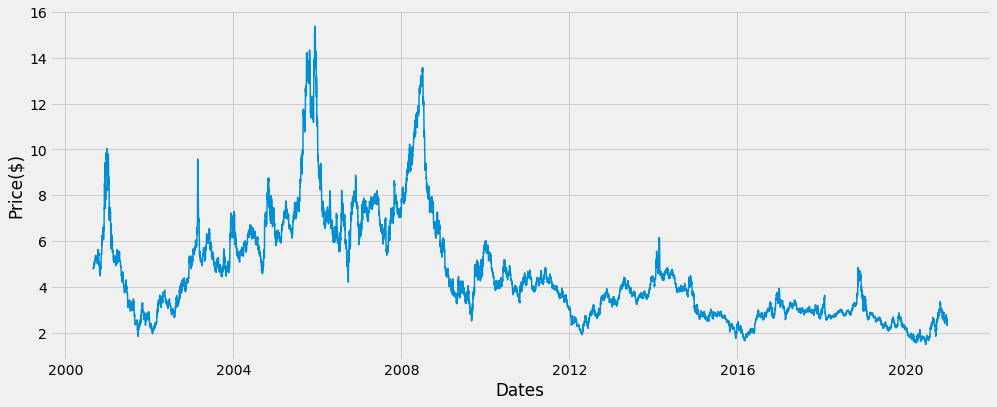

In [21]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.xlabel("Dates")
plt.ylabel("Price($)")
plt.show()

In [17]:
from scipy.signal import periodogram

In [18]:
f, Pxx_den = periodogram(train)

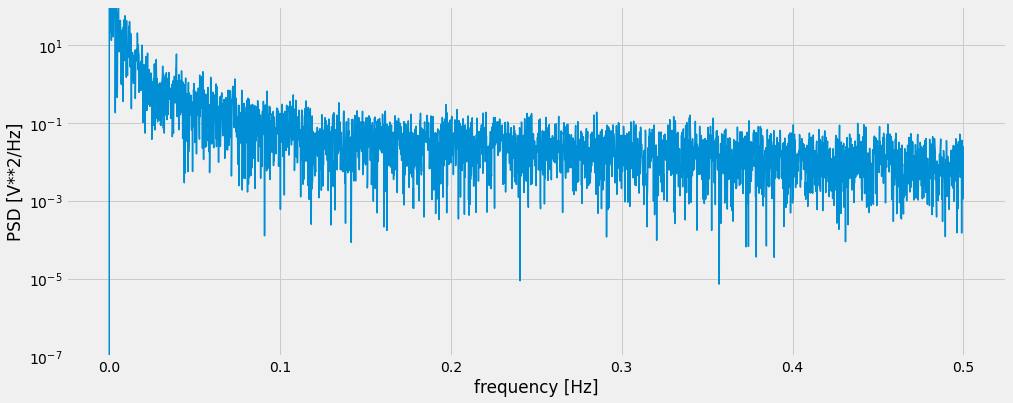

In [20]:
plt.figure(figsize=(15,6))
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#### It is hard to find the peak of the series, Let's print first few values

In [22]:
limit = 20
print(f"Frequency: {f[:limit]}")
print(f"Spectral Density: {Pxx_den[:limit]}")

Frequency: [0.         0.00013461 0.00026922 0.00040382 0.00053843 0.00067304
 0.00080765 0.00094225 0.00107686 0.00121147 0.00134608 0.00148068
 0.00161529 0.0017499  0.00188451 0.00201911 0.00215372 0.00228833
 0.00242294 0.00255754]
Spectral Density: [3.79309468e-30 2.03117900e+04 3.80112894e+03 9.43264311e+02
 2.17066312e+01 4.65066891e+02 9.78046715e+02 6.28481023e+02
 2.60986905e+03 1.77433133e+03 1.33196487e+01 3.35779584e+02
 6.36493619e+01 4.51341367e+02 1.13981055e+03 4.33592204e+02
 6.28908556e+02 7.06367604e+02 1.65184603e+01 6.38092067e+01]


In [23]:
max_idx = np.argmax(Pxx_den[:limit])
max_idx

1

In [31]:
print(f"The peak value of periodogram is the 2nd value,\nand that corresponds to a frequency of {f[max_idx]}.\nThe period for this value = 1/{f[max_idx]} = {1006}")

SyntaxError: f-string: unmatched ')' (1033597798.py, line 1)

In [25]:
forecast_len = len(val)

num_features=1006
pipe = pipeline.Pipeline([
        ("fourier", ppc.FourierFeaturizer(num_features)),
        ("arima", arima.ARIMA((13,1,23)))
    ])

In [26]:
pipe.fit(train.values)

Pipeline(steps=[('fourier', FourierFeaturizer(m=1006)),
                ('arima', ARIMA(order=(13, 1, 23)))])

In [27]:
output = pipe.predict(forecast_len)

In [28]:
len(val), len(output)

(209, 209)

In [29]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, output))

print(rmse)

r2_score(test, output)

4.037837339939472


-4.15445347621656

In [32]:
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7429
Model:             SARIMAX(13, 1, 23)   Log Likelihood                3611.285
Date:                Fri, 26 Aug 2022   AIC                          -5134.570
Time:                        15:57:59   BIC                           2082.614
Sample:                             0   HQIC                         -2655.045
                               - 7429                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -8.189e-05      0.001     -0.076      0.940      -0.002       0.002
FOURIER_S1006-0      -0.5619      0.696     -0.807      0.420      -1.927       0.803
FOURIER_C1006-0       0.5087      0.658      0.773      0.440      -0.782       1.799
FOURIER_S1006-1      -0.4337      0.355     -1.223      0.221      -1.129       0.261
FOURIER_C1006-1       0.0146      0.323      0.045      0.964      -0.619       0.648
FOURIER_S1006-2      -0.1269      0.225     -0.563      0.573      -0.568       0.315
FOURIER_C1006-2      -0.1697      0.229     -0.742      0.458      -0.618       0.278
FOURIER_S1006-3       0.0305      0.167      0.182      0.856      -0.298       0.359
FOURIER_C1006-3      -0.2344      0.173     -1.352      0.177      -0.574       0.105
FOURIER_S1006-4       0.0437      0.135      0.325      0.746      -0.220       0.308
FOURIER_C1006-4       0.0287      0.139      0.207      0.836      -0.244       0.301
FOURIER_S1006-5      -0.0192      0.113     -0.170      0.865      -0.240       0.202
FOURIER_C1006-5      -0.0223      0.116     -0.193      0.847      -0.249       0.205
FOURIER_S1006-6       0.0078      0.097      0.080      0.936      -0.183       0.199
FOURIER_C1006-6       0.0471      0.099      0.473      0.636      -0.148       0.242
FOURIER_S1006-7      -0.0133      0.087     -0.153      0.878      -0.183       0.157
FOURIER_C1006-7       0.0330      0.086      0.385      0.700      -0.135       0.201
FOURIER_S1006-8       0.0092      0.076      0.121      0.904      -0.140       0.158
FOURIER_C1006-8      -0.0127      0.078     -0.164      0.870      -0.165       0.139
FOURIER_S1006-9       0.0915      0.069      1.321      0.186      -0.044       0.227
FOURIER_C1006-9      -0.0311      0.069     -0.448      0.654      -0.167       0.105
FOURIER_S1006-10      0.0391      0.063      0.625      0.532      -0.084       0.162
FOURIER_C1006-10     -0.0100      0.063     -0.159      0.874      -0.133       0.113
FOURIER_S1006-11      0.0357      0.059      0.606      0.544      -0.080       0.151
FOURIER_C1006-11      0.0799      0.056      1.431      0.152      -0.030       0.189
FOURIER_S1006-12     -0.0089      0.054     -0.165      0.869      -0.115       0.097
FOURIER_C1006-12      0.0228      0.051      0.446      0.656      -0.077       0.123
FOURIER_S1006-13     -0.0272      0.049     -0.553      0.580      -0.123       0.069
FOURIER_C1006-13      0.0015      0.048      0.030      0.976      -0.092       0.095
FOURIER_S1006-14     -0.0512      0.046     -1.107      0.268      -0.142       0.039
FOURIER_C1006-14     -0.0141      0.043     -0.325      0.745      -0.099       0.071
FOURIER_S1006-15     -0.0347      0.042     -0.834      0.405      -0.116       0.047
FOURIER_C1006-15     -0.0192      0.041     -0.465      0.642      -0.100       0.062
FOURIER_S1006-16     -0.0059      0.039     -0.152      0.880      -0.083       0.071
FOURIER_C1006-16     -0.0515      0.038     -1.357      0.1

In [33]:
def calc_conf_inv(pred, level):
    '''function to calculate confidence intervals for given significance level'''
    alpha_dct = {90:1.64, 95:1.96, 96:2.05, 97:2.17, 98:2.33, 99:2.58}
    alpha = alpha_dct[level]
    
    stdev = np.std(pred)
    uncertainity = alpha*stdev
    
    lower_bound = pred - uncertainity
    upper_bound = pred + uncertainity
    
    results = pd.DataFrame({'Predictions':pred, 'Lower Bound':lower_bound, 'Upper Bound':upper_bound})
    
    return results

In [47]:
def plot_from_res(train, test, pred, aic, title=None):
    pred.index=test.index
    rmse = mean_squared_error(test, pred, squared=False)
    
    fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.plot(train, label='Train')
    
    ax.plot(pred, label='Forecast', color='black')

    ax.plot(test, label="Test (RMSE={:0.2f}, AIC={:0.2f})".format(rmse, aic), color='green')
    
    ax.legend(loc='best')
    plt.xlabel('Dates', fontsize=18)
    plt.ylabel('Prices($)', fontsize=16)
    ax.grid(True)
    plt.show()

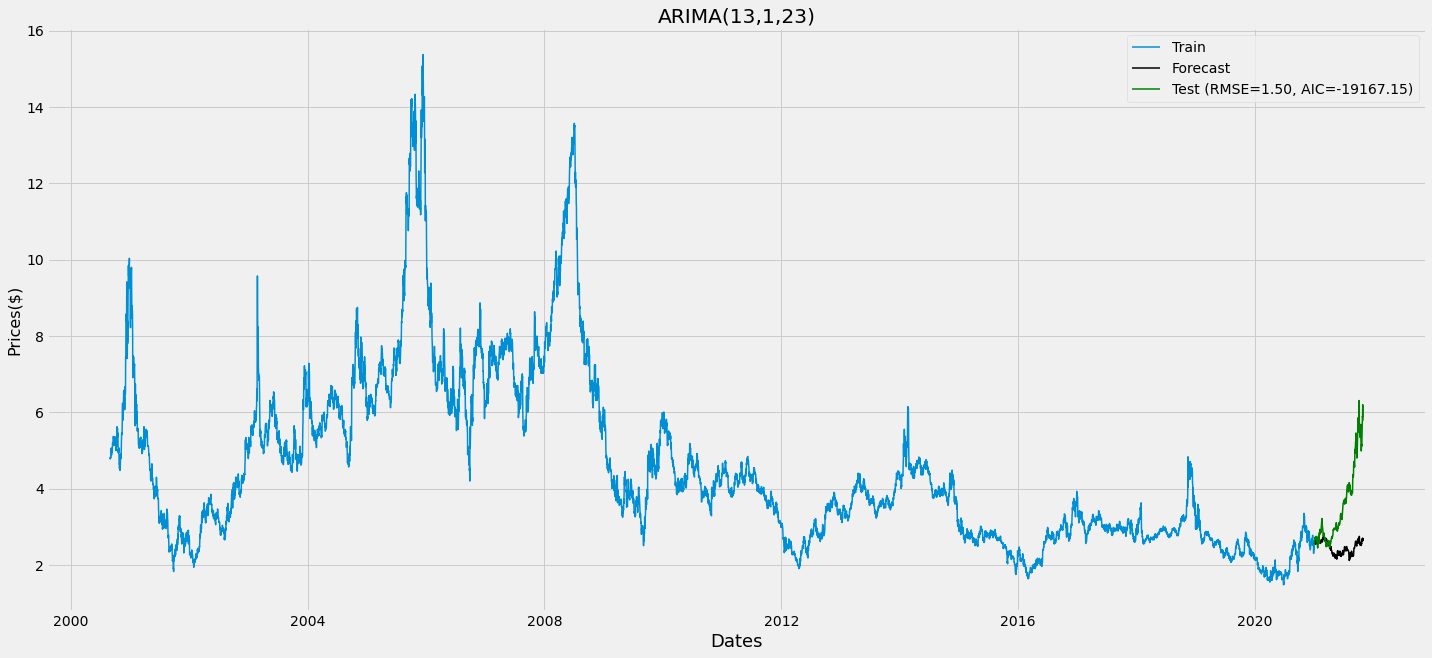

In [48]:
plt.rcParams.update({'figure.figsize': (22,10)})
plot_from_res(train, val, pd.Series(output), -19167.145, title="ARIMA(13,1,23)")

In [37]:
start = datetime(2021,1,1)
end = datetime(2026,1,1)
end-start

datetime.timedelta(days=1826)

In [38]:
output5 = pipe.predict(1827)

In [39]:
dates = pd.date_range(start,end)

In [40]:
arima_preds = pd.DataFrame({"Preds":np.exp(output5)}, index=dates).reset_index()

In [41]:
arima_preds.rename(columns={'index':'Date'},inplace=True)

In [44]:
arima_preds.index=arima_preds['Date']

In [51]:
arima_conf = calc_conf_inv(arima_preds["Preds"], 95)
arima_conf.head()

,Predictions,Lower Bound,Upper Bound
Date,,,
2021-01-01,12.978117,-28.825191,54.781426
2021-01-02,13.139714,-28.663595,54.943022
2021-01-03,13.907636,-27.895673,55.710944
2021-01-04,13.716978,-28.086331,55.520286
2021-01-05,14.154430,-27.648879,55.957738


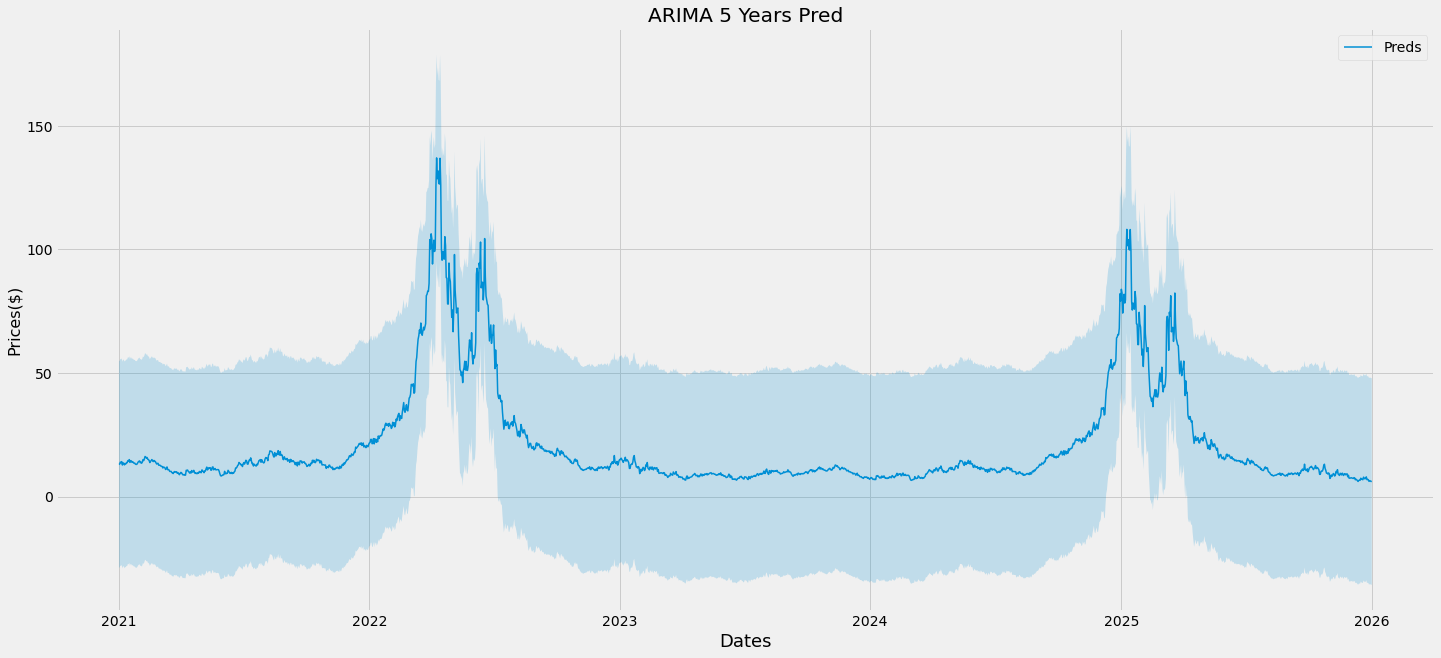

In [50]:
fig, ax = plt.subplots()
ax.set_title('ARIMA 5 Years Pred')
ax.plot(arima_conf['Predictions'], label='Preds')

ax.fill_between(arima_conf.index, arima_conf['Lower Bound'], arima_conf['Upper Bound'], alpha=0.2)
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Prices($)', fontsize=16)
ax.legend(loc='best')
plt.show()

In [119]:
arima_conf.to_csv("preds/arima complete.csv")